In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1708680018000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1708678578000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1708680002000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.zip', name='clinicaltrial_2021.zip', size=11508457, modificationTime=1708678580000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023-2.zip', name='clinicaltrial_2023-2.zip', size=52785750, modificationTime=1708155889000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1708679957000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023_1/', name='clinicaltrial_2023_1/', size=0, modificationTime=0),
 FileIn

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from pyspark.sql.types import StructType, StructField, StringType

# Start Spark session
spark = SparkSession.builder.appName("clinical_trials").getOrCreate()

# Define the schema based on the provided fields
schema = StructType([
    StructField("Id", StringType(), True),
    StructField("Study Title", StringType(), True),
    StructField("Acronym", StringType(), True),
    StructField("Study Status", StringType(), True),
    StructField("Conditions", StringType(), True),
    StructField("Interventions", StringType(), True),
    StructField("Sponsor", StringType(), True),
    StructField("Collaborators", StringType(), True),
    StructField("Enrollment", StringType(), True),
    StructField("Funder Type", StringType(), True),
    StructField("Study Type", StringType(), True),
    StructField("Study Design", StringType(), True),
    StructField("Start Date", StringType(), True),
    StructField("Completion Date", StringType(), True)
])

# Load data as a single column of text
data_path = "/FileStore/tables/clinicaltrial_2023.csv"
df_raw = spark.read.text(data_path)

# Correctly split the "value" column by actual tab character
df_processed = df_raw.withColumn("value", split(col("value"), "\t"))

# Extract columns based on the schema
# Adjust the indexing if necessary to skip any header-like rows repeated in the data
df_final = df_processed.select([df_processed["value"].getItem(i).alias(field.name) for i, field in enumerate(schema.fields)])

df_filtered = df_final.filter(df_final["Id"] != "\"Id")
# Optionally, filter out the first row if it's a header or any non-data row
# Here, you would need a condition to identify such rows, like checking if "Id" matches a pattern

# Show the DataFrame to verify correct loading
df_filtered.show(5, truncate=False)


+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------+------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------+------------------------------------------------------------------------------------+----------+-----------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id          |Study Title                                               

In [0]:
# adding "completion_date" column
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import date_format
df_filtered = df_filtered.withColumn('Completion Date', regexp_replace('Completion Date', '\"|,+', ''))

In [0]:
from pyspark.sql.functions import col, count, lit, when
from pyspark.sql.window import Window

# Function to calculate mode for a given column
def calculate_mode(df, column_name):
    # Group by the column, count occurrences, and order to find the mode
    mode_df = df.groupBy(column_name) \
                .agg(count(lit(1)).alias("freq")) \
                .orderBy(col("freq").desc())
    
    # Get the most frequent value (mode)
    mode_value = mode_df.first()[0]
    return mode_value

# Function to fill missing values with mode for each specified column
def fill_with_mode(df, columns):
    for column in columns:
        mode_value = calculate_mode(df.filter(col(column).isNotNull()), column)
        # Fill missing values in the DataFrame with the mode
        df = df.withColumn(column, when(col(column).isNull(), mode_value).otherwise(col(column)))
    return df

# Columns to fill with mode
columns_to_fill = ["Study Title", "Acronym", "Study Status", "Conditions", "Interventions", "Sponsor", "Collaborators", "Enrollment", "Funder Type", "Study Type", "Study Design", "Start Date"]

# Apply the function to fill missing values with mode
df_filtered = fill_with_mode(df_filtered, columns_to_fill)

# Show the DataFrame to verify that missing values are filled
df_filtered.show(5, truncate=False)


+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------+------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------+------------------------------------------------------------------------------------+----------+-----------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------+----------+---------------+
|Id          |Study Title                                                                                                                                                   |Acronym   |Study Status      |Conditions                                                                 

In [0]:
from pyspark.sql.functions import when, trim, col

# List of string columns to check for spaces and replace with "Unknown"
columns_to_fill = ["Study Title", "Acronym", "Study Status", "Conditions", "Interventions", "Sponsor", "Collaborators", "Enrollment", "Funder Type", "Study Type", "Study Design", "Start Date"] # Add other string columns as needed

for column in columns_to_fill:
    df_filtered = df_filtered.withColumn(column, when(trim(col(column)) == "", "Unknown").otherwise(col(column)))


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.functions import split, col

# Start Spark session
spark = SparkSession.builder.appName("pharmacy_dataset").getOrCreate()

# Define the schema based on the pharmacy dataset fields
schema = StructType([
    StructField("Company", StringType(), True),
    StructField("Parent_Company", StringType(), True),
    StructField("Penalty_Amount", IntegerType(), True),
    StructField("Subtraction_From_Penalty", IntegerType(), True),
    StructField("Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting", IntegerType(), True),
    StructField("Penalty_Year", IntegerType(), True),
    StructField("Penalty_Date", DateType(), True),
    StructField("Offense_Group", StringType(), True),
    StructField("Primary_Offense", StringType(), True),
    StructField("Secondary_Offense", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Level_of_Government", StringType(), True),
    StructField("Action_Type", StringType(), True),
    StructField("Agency", StringType(), True),
    StructField("Civil/Criminal", StringType(), True),
    StructField("Prosecution_Agreement", StringType(), True),
    StructField("Court", StringType(), True),
    StructField("Case_ID", StringType(), True),
    StructField("Private_Litigation_Case_Title", StringType(), True),
    StructField("Lawsuit_Resolution", StringType(), True),
    StructField("Facility_State", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Zip", StringType(), True),
    StructField("NAICS_Code", StringType(), True),
    StructField("NAICS_Translation", StringType(), True),
    StructField("HQ_Country_of_Parent", StringType(), True),
    StructField("HQ_State_of_Parent", StringType(), True),
    StructField("Ownership_Structure", StringType(), True),
    StructField("Parent_Company_Stock_Ticker", StringType(), True),
    StructField("Major_Industry_of_Parent", StringType(), True),
    StructField("Specific_Industry_of_Parent", StringType(), True),
    StructField("Info_Source", StringType(), True),
    StructField("Notes", StringType(), True)
])

# Assuming the delimiter is '|', update the path to your pharmacy dataset
data_path = "/FileStore/tables/pharma.csv"
df_pharmacy = spark.read.option("header", "true").csv(data_path, schema=schema, sep=",")
df_pharmacy.show(2)


+--------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+------------------+---------------------+-----+-------+-----------------------------+------------------+--------------+----+-------+----+----------+-----------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+--------------------+-----+
|             Company|     Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|       Offense_Group|     Primary_Offense|   Secondary_Offense|         Description|Level_of_Government|  Action_Type|              Agency|    Civil/Criminal|Prosecution_Agreement|Court|Case_ID|

In [0]:
string_columns = [field.name for field in schema.fields if isinstance(field.dataType, StringType)]

for column in string_columns:
    df_pharmacy = df_pharmacy.na.fill({column: "Unknown"})


In [0]:
integer_columns = [field.name for field in schema.fields if isinstance(field.dataType, IntegerType)]

for column in integer_columns:
    df_pharmacy = df_pharmacy.na.fill({column: 0})


In [0]:
# Question 1: Number of Studies in the dataset
distinct_studies_rdd = df_filtered.rdd.map(lambda row: row["Id"]).distinct().count()
distinct_studies_rdd

Out[9]: 483422

In [0]:
#Question 2: Types of studies and their frequencies
study_type_freq_rdd = (df_filtered.rdd
                       .map(lambda row: (row["Study Type"], 1))
                       .reduceByKey(lambda a, b: a + b)
                       .sortBy(lambda pair: pair[1], ascending=False))


In [0]:
# Applying the action to collect results
study_type_freq_list = study_type_freq_rdd.collect()

# Display the results
for study_type, count in study_type_freq_list:
    print(f"{study_type}: {count}")


INTERVENTIONAL: 371384
OBSERVATIONAL: 110221
EXPANDED_ACCESS: 928
Unknown: 889


In [0]:
#Question 3: Top 5 conditions with frequencies
top_conditions_rdd = (df_filtered.rdd
                      .map(lambda row: (row["Conditions"], 1))
                      .reduceByKey(lambda a, b: a + b)
                      .takeOrdered(5, key=lambda x: -x[1]))


In [0]:
top_conditions_rdd

Out[13]: [('Healthy', 7997),
 ('Breast Cancer', 4556),
 ('Prostate Cancer', 2650),
 ('Asthma', 2309),
 ('Obesity', 2284)]

In [0]:
pharma_companies = [row[0] for row in df_pharmacy.select("Parent_Company").distinct().collect()]


In [0]:
from pyspark import SparkContext
sc = SparkSession.builder.getOrCreate().sparkContext
broadcast_pharma_companies = sc.broadcast(pharma_companies)


In [0]:
#Question 4: Top 10 most common sponsors that are not phramaceutical 
top_sponsors_rdd = (df_filtered.rdd
                    .filter(lambda row: row["Sponsor"] not in broadcast_pharma_companies.value)
                    .map(lambda row: (row["Sponsor"], 1))
                    .reduceByKey(lambda a, b: a + b)
                    .takeOrdered(10, key=lambda x: -x[1]))
top_sponsors_rdd


Out[16]: [('National Cancer Institute (NCI)', 3410),
 ('Assiut University', 3335),
 ('Cairo University', 3023),
 ('Assistance Publique - Hôpitaux de Paris', 2951),
 ('Mayo Clinic', 2766),
 ('M.D. Anderson Cancer Center', 2702),
 ('Novartis Pharmaceuticals', 2393),
 ('National Institute of Allergy and Infectious Diseases (NIAID)', 2340),
 ('Massachusetts General Hospital', 2263),
 ('National Taiwan University Hospital', 2181)]

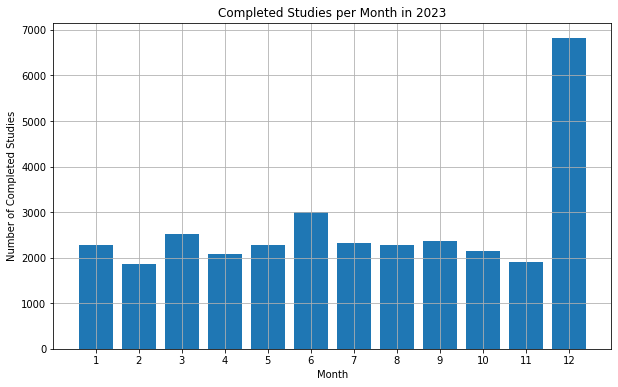

,month,count
0,1,2285
1,2,1861
2,3,2523
3,4,2081
4,5,2286
5,6,3003
6,7,2329
7,8,2281
8,9,2356
9,10,2144


In [0]:
# Question 5: Plot number of completed studies for each month in 2023
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, year, month
# Convert "Completion Date" from string to date format
df_filtered = df_filtered.withColumn("Completion Date", to_date(df_filtered["Completion Date"], "yyyy-MM-dd"))

# Filter for 2023 and group by month
completed_studies_df = df_filtered.filter(year("Completion Date") == 2023) \
    .groupBy(month("Completion Date").alias('month')) \
    .count() \
    .orderBy('month')

# Convert to Pandas DataFrame for plotting
completed_studies_pd = completed_studies_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(completed_studies_pd['month'], completed_studies_pd['count'])
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Completed Studies per Month in 2023')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# Display table of values
completed_studies_pd

In [0]:
#further analysis 
from datetime import datetime

# Function to parse the date and extract the year
def get_year_from_date(date_string):
    # Assuming the date format is "yyyy-MM-dd"
    # Adjust the format as necessary to match your dataset
    try:
        return datetime.strptime(date_string, "%Y-%m-%d").year
    except:
        return None  # Returning None for rows with invalid or missing dates

# Adjusted RDD operation
study_year_distribution = (df_filtered.rdd
                           .map(lambda row: (get_year_from_date(row["Start Date"]), 1))
                           .filter(lambda x: x[0] is not None)  # Filter out None values
                           .reduceByKey(lambda a, b: a + b)
                           .sortByKey()
                           .collect())

# Display the results
for year, count in study_year_distribution:
    print(f"Year: {year}, Count: {count}")


Year: 1916, Count: 1
Year: 1917, Count: 1
Year: 1963, Count: 1
Year: 1968, Count: 1
Year: 1972, Count: 1
Year: 1973, Count: 2
Year: 1975, Count: 1
Year: 1976, Count: 5
Year: 1977, Count: 8
Year: 1978, Count: 2
Year: 1979, Count: 4
Year: 1980, Count: 2
Year: 1981, Count: 2
Year: 1983, Count: 5
Year: 1984, Count: 10
Year: 1985, Count: 4
Year: 1986, Count: 2
Year: 1987, Count: 3
Year: 1988, Count: 7
Year: 1989, Count: 17
Year: 1990, Count: 18
Year: 1991, Count: 25
Year: 1992, Count: 28
Year: 1993, Count: 41
Year: 1994, Count: 39
Year: 1995, Count: 56
Year: 1996, Count: 84
Year: 1997, Count: 95
Year: 1998, Count: 117
Year: 1999, Count: 172
Year: 2000, Count: 245
Year: 2001, Count: 282
Year: 2002, Count: 330
Year: 2003, Count: 468
Year: 2004, Count: 577
Year: 2005, Count: 682
Year: 2006, Count: 926
Year: 2007, Count: 1047
Year: 2008, Count: 1239
Year: 2009, Count: 1535
Year: 2010, Count: 1879
Year: 2011, Count: 2236
Year: 2012, Count: 2871
Year: 2013, Count: 3701
Year: 2014, Count: 5044
Yea

In [0]:
#further analysis 
def safe_float_conversion(enrollment):
    try:
        # Attempt to convert the enrollment value to a float
        return float(enrollment)
    except (ValueError, TypeError):
        # Return a default value if the conversion fails
        return 0.0

# Apply the safe conversion function to the RDD transformation
study_type_avg_enrollment = (
    df_filtered.rdd
    .map(lambda row: (row["Study Type"], (safe_float_conversion(row["Enrollment"]), 1)))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .mapValues(lambda x: x[0] / x[1] if x[1] > 0 else 0)  # Avoid division by zero
    .sortBy(lambda x: x[1], ascending=False)
    .collect()
)

# Display the results
for item in study_type_avg_enrollment:
    print(item)


('OBSERVATIONAL', 18859.205115177687)
('INTERVENTIONAL', 1225.1344322857205)
('Unknown', 0.0)
('EXPANDED_ACCESS', 0.0)


In [0]:
#further analysis 
(df_filtered.rdd
 .filter(lambda row: row["Collaborators"] is not None)
 .map(lambda row: (row["Collaborators"], 1))
 .reduceByKey(lambda a, b: a + b)
 .takeOrdered(5, key=lambda x: -x[1]))


Out[20]: [('Unknown', 325505),
 ('National Cancer Institute (NCI)', 7918),
 ('National Heart", Lung," and Blood Institute (NHLBI)', 1689),
 ('National Institute of Mental Health (NIMH)', 1590),
 ('National Institute on Drug Abuse (NIDA)', 1394)]